<a href="https://colab.research.google.com/github/kaledai069/Crossword-Solver-A-Neural-Transformer-based-Approach/blob/master/BCS_Dataset_Split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Lets Split the BCS - Train-Validation Dataset into Shards for Training DistilBERT**

In [57]:
!pip install -q git+https://github.com/alexdej/puzpy.git
!pip install -q xword-dl
!pip install -q wordsegment

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xword-dl 2023.12.2 requires puzpy==0.2.5, but you have puzpy 0.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.1 MB/s eta 0:00:00


#### Lets accumulate all the CSV file from 2021 first

In [118]:
import unicodedata
import re
import numpy as np
import matplotlib.pyplot as plt
import datetime
import subprocess
import puz
import glob
import os
import json
import pandas as pd

from tqdm import tqdm
from pprint import pprint
from wordsegment import load, segment
from sklearn.model_selection import train_test_split
load()

#### Preprocess Clues

In [55]:
def preprocess_clue_fn(clue):
    clue = str(clue)

    clue = ''.join(c for c in unicodedata.normalize('NFD', clue) if unicodedata.category(c) != 'Mn')

    clue = re.sub("\x17|\x18|\x93|\x94|“|”|''|\"\"", "\"", clue)
    clue = re.sub("\x85|…", "...", clue)
    clue = re.sub("\x91|\x92|‘|’", "'", clue)

    clue = re.sub("‚", ",", clue)
    clue = re.sub("—|–", "-", clue)
    clue = re.sub("¢", " cents", clue)
    clue = re.sub("¿|¡|^;|\{|\}", "", clue)
    clue = re.sub("÷", "division", clue)
    clue = re.sub("°", " degrees", clue)

    euro = re.search("^£[0-9]+(,*[0-9]*){0,}| £[0-9]+(,*[0-9]*){0,}", clue)
    if euro:
        num = clue[:euro.end()]
        rest_clue = clue[euro.end():]
        clue = num + " Euros" + rest_clue
        clue = re.sub(", Euros", " Euros", clue)
        clue = re.sub("Euros [Mm]illion", "million Euros", clue)
        clue = re.sub("Euros [Bb]illion", "billion Euros", clue)
        clue = re.sub("Euros[Kk]", "K Euros", clue)
        clue = re.sub(" K Euros", "K Euros", clue)
        clue = re.sub("£", "", clue)

    clue = re.sub(" *\(\d{1,},*\)$| *\(\d{1,},* \d{1,}\)$", "", clue)

    clue = re.sub("&amp;", "&", clue)
    clue = re.sub("&lt;", "<", clue)
    clue = re.sub("&gt;", ">", clue)

    clue = re.sub("e\.g\.|for ex\.", "for example", clue)
    clue = re.sub(": [Aa]bbreviat\.|: [Aa]bbrev\.|: [Aa]bbrv\.|: [Aa]bbrv|: [Aa]bbr\.|: [Aa]bbr", " abbreviation", clue)
    clue = re.sub("abbr\.|abbrv\.", "abbreviation", clue)
    clue = re.sub("Abbr\.|Abbrv\.", "Abbreviation", clue)
    clue = re.sub("\(anag\.\)|\(anag\)", "(anagram)", clue)
    clue = re.sub("org\.", "organization", clue)
    clue = re.sub("Org\.", "Organization", clue)
    clue = re.sub("Grp\.|Gp\.", "Group", clue)
    clue = re.sub("grp\.|gp\.", "group", clue)
    clue = re.sub(": Sp\.", " (Spanish)", clue)
    clue = re.sub("\(Sp\.\)|Sp\.", "(Spanish)", clue)
    clue = re.sub("Ave\.", "Avenue", clue)
    clue = re.sub("Sch\.", "School", clue)
    clue = re.sub("sch\.", "school", clue)
    clue = re.sub("Agcy\.", "Agency", clue)
    clue = re.sub("agcy\.", "agency", clue)
    clue = re.sub("Co\.", "Company", clue)
    clue = re.sub("co\.", "company", clue)
    clue = re.sub("No\.", "Number", clue)
    clue = re.sub("no\.", "number", clue)
    clue = re.sub(": [Vv]ar\.", " variable", clue)
    clue = re.sub("Subj\.", "Subject", clue)
    clue = re.sub("subj\.", "subject", clue)
    clue = re.sub("Subjs\.", "Subjects", clue)
    clue = re.sub("subjs\.", "subjects", clue)

    theme_clue = re.search("^.+\|[A-Z]{1,}", clue)
    if theme_clue:
        clue = re.sub("\|", " | ", clue)

    if "Partner of" in clue:
        clue = re.sub("Partner of", "", clue)
        clue = clue + " and ___"

    link = re.search("^.+-.+ [Ll]ink$", clue)
    if link:
        no_link = re.search("^.+-.+ ", clue)
        x_y = clue[no_link.start():no_link.end() - 1]
        x_y_lst = x_y.split("-")
        clue = x_y_lst[0] + " ___ " + x_y_lst[1]

    follower = re.search("^.+ [Ff]ollower$", clue)
    if follower:
        no_follower = re.search("^.+ ", clue)
        x = clue[:no_follower.end() - 1]
        clue = x + " ___"

    preceder = re.search("^.+ [Pp]receder$", clue)
    if preceder:
        no_preceder = re.search("^.+ ", clue)
        x = clue[:no_preceder.end() - 1]
        clue = "___ " + x

    if re.search("--[^A-Za-z]|--$", clue):
        clue = re.sub("--", "__", clue)
    if not re.search("_-[A-Za-z]|_-$", clue):
        clue = re.sub("_-", "__", clue)

    clue = re.sub("_{2,}", "___", clue)

    clue = re.sub("\?$", " (wordplay)", clue)

    nonverbal = re.search("\[[^0-9]+,* *[^0-9]*\]", clue)
    if nonverbal:
        clue = re.sub("\[|\]", "", clue)
        clue = clue + " (nonverbal)"

    if clue[:4] == "\"\"\" " and clue[-4:] == " \"\"\"":
        clue = "\"" + clue[4:-4] + "\""
    if clue[:4] == "''' " and clue[-4:] == " '''":
        clue = "'" + clue[4:-4] + "'"
    if clue[:3] == "\"\"\"" and clue[-3:] == "\"\"\"":
        clue = "\"" + clue[3:-3] + "\""
    if clue[:3] == "'''" and clue[-3:] == "'''":
        clue = "'" + clue[3:-3] + "'"

    return clue

#### Prepare Clues and Answer for Training (2021)

In [62]:
CSV_file_paths = glob.glob('./*.csv')
all_CA_pairs = []

CA_df = pd.DataFrame(columns = ['Clue', 'Answer'])
for file_path in CSV_file_paths:
    temp_df = pd.read_csv(file_path)
    CA_df = pd.concat([CA_df, temp_df[['Clue', 'Answer']]], axis = 0, ignore_index = True)

CA_df['Clue'] = CA_df['Clue'].apply(lambda x: preprocess_clue_fn(x).lower() if isinstance(x, str) else 'UJJWAL')
CA_df['Answer'] = CA_df['Answer'].apply(lambda x: x.lower() if isinstance(x, str) else 'UJJWAL')

print("Before excluding 'NAN': ", len(CA_df))
CA_df = CA_df[~(CA_df['Answer'] == 'UJJWAL')]
CA_df = CA_df[~(CA_df['Clue'] == 'UJJWAL')]
print("After excluding 'NAN': ", len(CA_df))

print("\nBefore excluding Duplicates: ", len(CA_df))
CA_df = CA_df.drop_duplicates(subset=['Clue', 'Answer'])
print("After excluding Duplicates: ", len(CA_df))

print("\nBefore excluding Duplicates from Segmented Answers: ", len(CA_df))
CA_df['Segmented Answer'] = CA_df['Answer'].apply(lambda x: " ".join(segment(x)))
CA_df = CA_df.drop_duplicates(subset=['Clue', 'Segmented Answer'])
print("After excluding Duplicates from Segmented Answers: ", len(CA_df))

Before excluding 'NAN':  135609
After excluding 'NAN':  135599

Before excluding Duplicates:  135599
After excluding Duplicates:  120990

Before excluding Duplicates from Segmented Answers:  120990
After excluding Duplicates from Segmented Answers:  120990


In [64]:
# lets save this 2021 only clue-answer pairs for future references
CA_df.to_csv('/content/gdrive/MyDrive/Clue-Answer Dataset/2021_CA_dataset.csv')

120990it [00:06, 18877.17it/s]


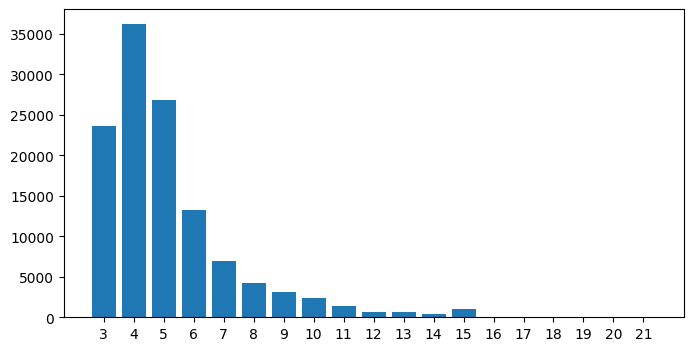

In [67]:
# lets analysze this 2021_referential CA dataset to the cool histogram plot
ans_histogram_ = {}
for row in tqdm(CA_df.iterrows(), ncols = 100):
    clue = row[1]['Clue']
    answer = row[1]['Answer']
    if isinstance(answer, float):
        continue
    if len(answer) in ans_histogram_:
        ans_histogram_[len(answer)] += 1
    else:
        ans_histogram_[len(answer)] = 1

hist_array = []
for ans_len, count in ans_histogram_.items():
    hist_array.append([ans_len, count])

hist_array.sort(key = lambda x: x[0])
hist_array = np.array(hist_array)

plt.figure(figsize = (8, 4))
plt.bar(hist_array[:, 0], hist_array[:, 1])
plt.xticks(hist_array[:, 0])
plt.show()

#### Lets start with the BCS dataset and analyze

In [75]:
root_BCS_path = '/content/gdrive/MyDrive/Clue-Answer Dataset/BCS - Dataset'
bcs_splitted_csv_paths = glob.glob(os.path.join(root_BCS_path, '*.csv'))

valid_df = pd.read_csv(bcs_splitted_csv_paths[0])
train_df = pd.read_csv(bcs_splitted_csv_paths[1])

print("Initial Training Split Size: ", len(train_df))
print("Initial Validation Split Size: ", len(valid_df))

Initial Training Split Size:  6420790
Initial Validation Split Size:  361458


In [93]:
bcs_answer_series = pd.concat([train_df['answer'], valid_df['answer']])
bcs_answer_list = bcs_answer_series.unique().tolist()

print("Total answers in BCS: ", len(bcs_answer_series))
print("Total unique answers in Train set: ", len(train_df['answer'].unique()))
print("Total unique answers in Validation set: ", len(valid_df['answer'].unique()))
print("Total unique answers in Overall set: ", len(bcs_answer_list))

Total answers in BCS:  6782248
Total unique answers in Train set:  437722
Total unique answers in Validation set:  83926
Total unique answers in Overall set:  447125


In [96]:
# now lets test how many of answers from the 2021 are in the BCS
bcs_segmented_answer_list = []
for ans in tqdm(bcs_answer_list, ncols = 120):
    bcs_segmented_answer_list.append(" ".join(segment(str(ans))))

100%|█████████████████████████████████████████████████████████████████████████| 447125/447125 [04:03<00:00, 1834.46it/s]


In [100]:
answer_2021_list = CA_df['Segmented Answer'].unique().tolist()

bcs_set = set(bcs_segmented_answer_list)
answer_2021_set = set(answer_2021_list)

print("Intersection between BCS and 2021-only Answer set: ", len(answer_2021_set.intersection(bcs_set)))

Intersection between BCS and 2021-only Answer set:  36477


In [103]:
# lets fine the overlap between the BCS train and validation set

bcs_overall_pairs = pd.concat([train_df, valid_df], ignore_index = True)
print("Overall BCS Clue-Answer pairs: ", len(bcs_overall_pairs))

bcs_overall_pairs.rename(columns={'clue': 'Clue', 'answer': 'Answer'}, inplace = True)
bcs_overall_pairs['Clue'] = bcs_overall_pairs['Clue'].apply(lambda x : preprocess_clue_fn(x).lower() if isinstance(x, str) else 'UJJWAL')
bcs_overall_pairs['Answer'] = bcs_overall_pairs['Answer'].apply(lambda x : x.lower().replace(" ", '') if isinstance(x, str) else 'UJJWAL')

bcs_overall_pairs = bcs_overall_pairs[~(bcs_overall_pairs['Clue'] == 'UJJWAL')]
bcs_overall_pairs = bcs_overall_pairs[~(bcs_overall_pairs['Answer'] == 'UJJWAL')]
print("BCS size after excluding 'NaNs': ", len(bcs_overall_pairs))

bcs_overall_pairs = bcs_overall_pairs.drop_duplicates(subset = ['Clue', 'Answer'])
print("BCS size after excluding Duplicates: ", len(bcs_overall_pairs))

Overall BCS Clue-Answer pairs:  6782248
BCS size after excluding 'NaNs':  6781566
BCS size after excluding Duplicates:  6617216


In [105]:
# to normalize between two datasets from BCS and 2021, lets just have similar technique behind word segmentation
bcs_overall_pairs['Segmented Answer'] = bcs_overall_pairs['Answer'].apply(lambda x: " ".join(segment(x)))

In [108]:
bcs_final_pairs = bcs_overall_pairs[['Clue', 'Segmented Answer']]
bcs_final_pairs.head()

,Clue,Segmented Answer
0,carol's about to tolerate bad language,swearing
1,explorer or actor sebastian,cabot
2,tv talk pioneer,paar
3,"utter failure, figuratively",lead balloon
4,ages and ages,e on


In [110]:
# lets concatenate bcs final pairs and the 2021-set
CA_2021_pairs = CA_df[['Clue', 'Segmented Answer']]
CA_2021_pairs.head()

,Clue,Segmented Answer
0,common surname like jones,smith
1,capital of norway,oslo
2,fill fully,sate
3,new employee,hire e
4,ear-cleaning implement,swab


In [111]:
bcs_all_pairs = pd.concat([bcs_final_pairs, CA_2021_pairs])
print("Final BCS pairs before dropping duplicates: ", len(bcs_all_pairs))
BCS_final = bcs_all_pairs.drop_duplicates(subset = ['Clue', 'Segmented Answer'])
print("Final BCS pairs After dropping duplicates: ", len(BCS_final))

Final BCS pairs before dropping duplicates:  6738206
Final BCS pairs After dropping duplicates:  6665320


In [113]:
BCS_final.to_csv("/content/gdrive/MyDrive/Clue-Answer Dataset/BCS - Dataset/bcs_final.csv")

#### Lets now split this into multiple sets

In [116]:
CA_dataset = BCS_final.sample(frac = 1, random_state = 69)
CA_dataset.reset_index(drop = True, inplace = True)

In [124]:
total_rows = len(CA_dataset)
print("Total Rows in the Dataset:", total_rows)

splits = []
no_splits = 5
split_size = total_rows // no_splits

for i in range(no_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size
    if end_idx > total_rows:
        end_idx = total_rows
    split = CA_dataset[start_idx : end_idx].copy()
    splits.append(split)

Total Rows in the Dataset: 6665320


In [125]:
for split in splits:
    print(len(split))

1333064
1333064
1333064
1333064
1333064


In [126]:
for i, split in tqdm(enumerate(splits), ncols = 60):
    train_split, valid_split = train_test_split(split, test_size = 0.062000024002, random_state = 69)

    train_split.to_csv(f"/content/gdrive/MyDrive/Clue-Answer Dataset/BCS - Dataset/Splits/train_shard_{i + 1}_cluedata.csv")
    valid_split.to_csv(f"/content/gdrive/MyDrive/Clue-Answer Dataset/BCS - Dataset/Splits/valid_shard_{i + 1}_cluedata.csv")

5it [00:15,  3.19s/it]
